In [268]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns


import scipy.stats as sp
from scipy.stats import norm, skew #for some statistics



In [269]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [270]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1030, 81) 
The test data size before dropping Id feature is : (430, 80) 

The train data size after dropping Id feature is : (1030, 80) 
The test data size after dropping Id feature is : (430, 79) 


# 데이터 전처리


- outlier 제거

- 지나치게 큰 이상치를 제거함으로써 안전한 모델을 만들수 있다 다른 이상치가 있을 수 있으나, 테스트 데이터에도 이상치가 있을 수 있으므로, 이상치를 모두 없애기보다는, 일부는 남겨서 더 강건한 모델을 구축할 수 있다. 

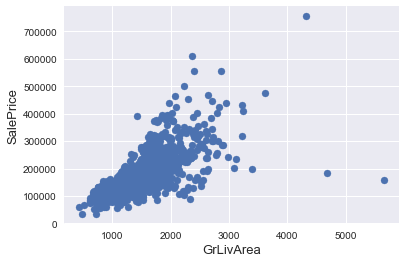

In [271]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

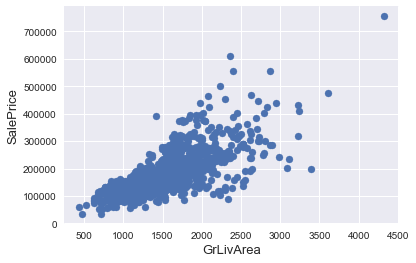

In [272]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# 목적 함수
- SalePrice
- regression에서 데이터들은 skewed 되지않고 정규분포에 가까울수록 좋은 결과가 나오므로
- QQ plot을 통해 정규분포인지 확인한다
- 아래에서는 skewed data이므로 정규분포를 따르게 하기위해 여기서는 log-transformation을 해주었다.

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 181547.39 and sigma = 78105.45



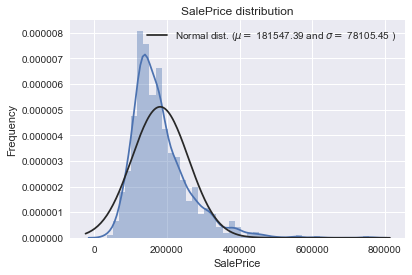

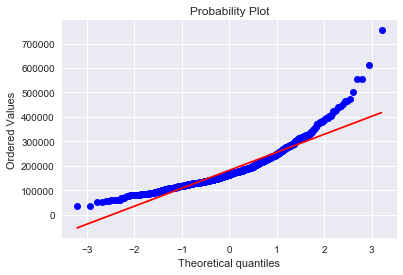

In [273]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 12.03 and sigma = 0.40



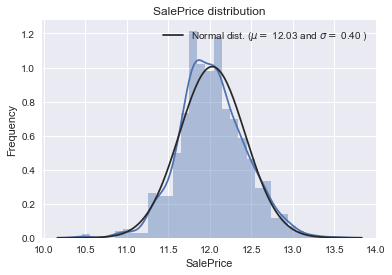

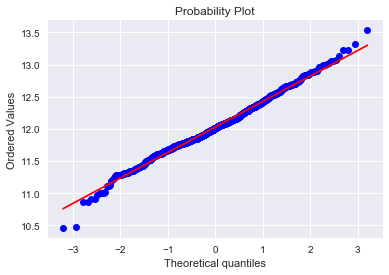

In [274]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

In [275]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1458, 79)


In [276]:
all_data

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706,0,...,WD,0,Pave,8,856,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978,0,...,WD,0,Pave,6,1262,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486,0,...,WD,0,Pave,6,920,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216,0,...,WD,0,Pave,7,756,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655,0,...,WD,0,Pave,9,1145,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,1Fam,TA,No,732,0,...,WD,0,Pave,5,796,AllPub,40,1993,1995,2009
6,1694,0,0,NaN,3,1Fam,TA,Av,1369,0,...,WD,0,Pave,7,1686,AllPub,255,2004,2005,2007
7,1107,983,0,NaN,3,1Fam,TA,Mn,859,32,...,WD,0,Pave,7,1107,AllPub,235,1973,1973,2009
8,1022,752,0,NaN,2,1Fam,TA,No,0,0,...,WD,0,Pave,8,952,AllPub,90,1931,1950,2008
9,1040,0,0,NaN,3,1Fam,TA,No,906,0,...,WD,0,Pave,5,1040,AllPub,0,1965,1965,2008


# Missing Data
- 데이터셋에는 NA로 된 데이터가 많았다. 
- 각 feature별로 isnull()함수를 통해 비어있는 칸을 구하고 그 비율을 구한다.  


In [277]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na[all_data_na > 0].sort_values(ascending = False)
all_data_na

PoolQC          99.588477
MiscFeature     96.296296
Alley           93.758573
Fence           80.727023
FireplaceQu     47.325103
LotFrontage     17.764060
GarageYrBlt      5.555556
GarageType       5.555556
GarageQual       5.555556
GarageFinish     5.555556
GarageCond       5.555556
BsmtFinType2     2.606310
BsmtExposure     2.606310
BsmtQual         2.537723
BsmtFinType1     2.537723
BsmtCond         2.537723
MasVnrArea       0.548697
MasVnrType       0.548697
Electrical       0.068587
dtype: float64

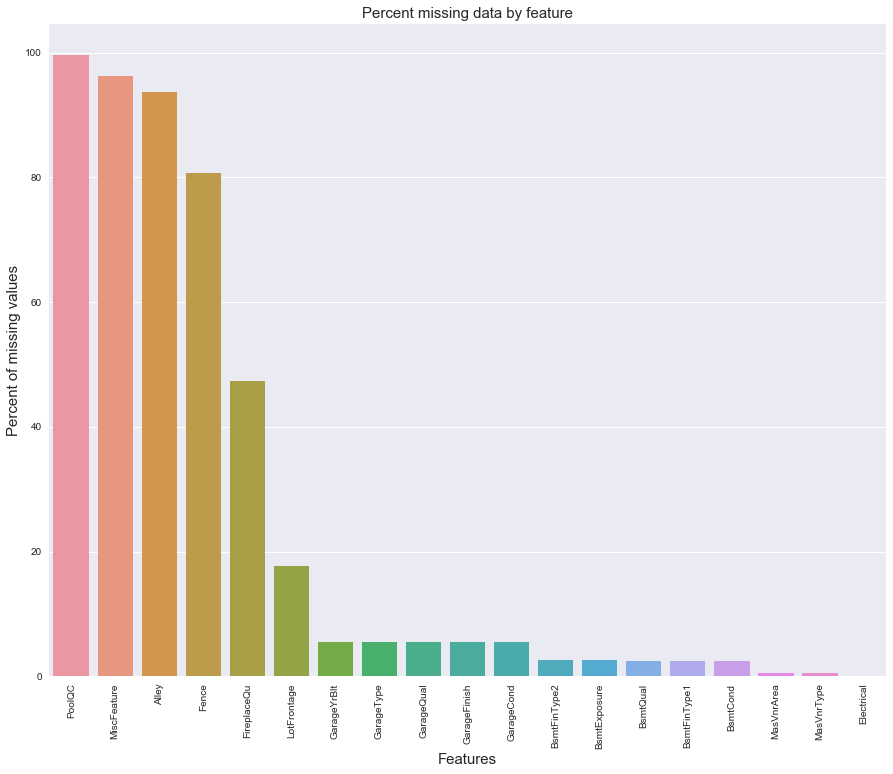

In [278]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# 상관분석

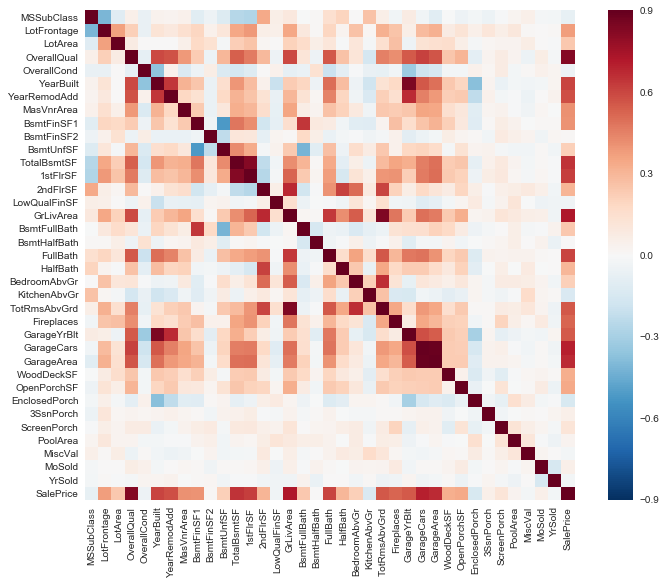

In [279]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [280]:
all_data["BsmtFinType2"]

0       Unf
1       Unf
2       Unf
3       Unf
4       Unf
5       Unf
6       Unf
7       BLQ
8       Unf
9       Unf
10      Unf
11      Unf
12      Unf
13      Unf
14      Unf
15      Unf
16      Unf
17      Unf
18      Unf
19      ALQ
20      Unf
21      Unf
22      Unf
23      Unf
24      Unf
25      Unf
26      Unf
27      Unf
28      Unf
29      NaN
       ... 
1428    Unf
1429    Unf
1430    Unf
1431    Unf
1432    Unf
1433    Unf
1434    Unf
1435    Unf
1436    Unf
1437    Unf
1438    Unf
1439    Unf
1440    Unf
1441    Unf
1442    Unf
1443    Unf
1444    Unf
1445    Unf
1446    Unf
1447    Unf
1448    Unf
1449    Unf
1450    Unf
1451    Rec
1452    Unf
1453    Unf
1454    Unf
1455    Rec
1456    Unf
1457    LwQ
Name: BsmtFinType2, dtype: object

# Missing data 채우기

- 데이터가 수치형 데이터(numeric data)와 범주형 데이터(categorical data)가 섞여있으므로 따로 채운다.
- 이를 분석하기 위해서 각 feature들의 의미를 정확히 분석할 필요가 있다.

- 다음은 missing data가 있는 feature들을 모아 Kaggle에서 나온 feature들의 설명을 덧붙인 것이다.

- PoolQC         : Pool quality (풀장의 질, Nan이면 없는것 : /범주형)
- MiscFeature    : Miscellaneous feature not covered in other categories(기타: None /??)
- Alley          : Type of alley access (근접한 골목 종류 Nan이면 없는것 : /범주형
- Fence          : Fence quality (울타리의 질, Nan이면 없는것 :/ 범주형)
- FireplaceQu    : Fireplace quality (난로의 질: Nan이면 없는것 :/ 범주형)
- LotFrontage    : Linear feet of street connected to property (집의 너비 Nan은 임의로 같은 이웃을 가진 index들의 평균값으로 설정 : /수치형)
- GarageYrBlt    : Year garage was built (차고 지어진 년수 Nan이면 없는것 : 0 /수치형)
- GarageType     : Garage location (차고 종류 Nan이면 없는것 : None /범주형)
- GarageQual     : Garage quality  (차고 질 Nan이면 없는것 : None /범주형)
- GarageFinish   : Interior finish of the garage (차고 마감 Nan이면 없는것 : None /범주형)
- GarageCond     : General condition of the basement (차고 상태 Nan이면 없는것 : None/ 범주형)
- BsmtFinType2   : Quality of second finished area (if present) (지하실 없으면 Nan : None/범주형)
- BsmtExposure   : Walkout or garden level basement walls (지하실 없으면 Nan : None/범주형)
- BsmtQual       : Height of the basement (지하실의 높이 지하실 없으면 Nan : None/범주형)
- BsmtFinType1   : Quality of basement finished area (지하실 없으면 Nan: None/범주형)
- BsmtCond       : General condition of the basement (지하실 상태 지하실 없으면 Nan:None /범주형)
- MasVnrArea     : Masonry veneer area in square feet (벽돌 지역 없으면 Nan: 0/수치형
- MasVnrType     : Masonry veneer type (벽돌 지역 없으면 Nan: 0/수치형)
- Electrical     : Electrical system (전기 없으면 Nan:none/범주형)

## None으로 바꿔야할 Features
- 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond','BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond', 'MasVnrType', 'Electrical'

In [281]:
to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
           'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond',
           'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1',
           'BsmtCond', 'MasVnrType', 'Electrical']
all_data[to_none] = all_data[to_none].fillna("None")

## 0으로 바꿔야할 Features
- 'MasVnrArea',' GarageYrBlt'

- LotFrontage는 누락된 것으로 보이므로 이웃들의 평균값으로 가정한다. 

In [282]:
to_zero = ['MasVnrArea','GarageYrBlt']
all_data[to_zero] = all_data[to_zero].fillna(0)


In [283]:
#Group by neighborhood and fill in missing value by the mean LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [284]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


## 수치이지만 실제로는 범주형 데이터인 것들
- 건물 클래스는 범주형이다.(MSSubClass)
- 전체적인 건물상태 -> 범주형 (OverallCond)
- 팔린 년도, 월은 범주형 (참고: 시계열 데이터는 범주형도 수치형도 아니고, 분석 목적에 따라 변할 수 있다. 예를 들어 시간에 따라 점차적으로 수치가 변화한다면 수치데이터, 이와같이 특정한 년, 월을 기준으로 한다면 범주형 데이터로 분석한다. (YrSold, MoSold)

In [285]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [288]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
PoolArea,15.542400
3SsnPorch,7.986887
LowQualFinSF,7.787002
MiscVal,6.461185
KitchenAbvGr,4.103816
BsmtHalfBath,3.957992
ScreenPorch,3.244481
BsmtFinSF2,2.773770
EnclosedPorch,2.235340
LotArea,1.914258


In [289]:
skewness = skewness[abs(skewness) > 0.75].dropna()

transfor = skewness.index

all_data[transfor] = sp.boxcox(1+all_data[transfor], 0.3)


In [290]:
all_data = pd.get_dummies(all_data)

In [291]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print(train.shape)
print(test.shape)



(1028, 339)
(430, 339)


In [292]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [313]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    print(cross_val_score(model, train.values, y_train, cv=kf))
    print(model.predict(test))
    return(rmse)

In [314]:
linear = make_pipeline(RobustScaler(), LinearRegression())

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0003, max_iter=10000, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0003, max_iter=10000, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=1.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

scroe = rmsle_cv(linear)
print('linear : {:.4f}({:.4f})\n'.format(score.mean(), score.std()))

score = rmsle_cv(lasso)

print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


[ 0.88655461  0.90420148  0.85351387  0.87483426  0.88709934]


NotFittedError: This RobustScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [317]:
GBoost.fit(train.values, y_train)
predict = GBoost.predict(test)
predict = np.expm1(predict)
predict

array([ 135691.54052186,  127872.53457792,  146486.06589571,
        107929.15581375,  119852.9471965 ,  251380.36091005,
        138534.49080187,  105159.03624857,  279553.1624927 ,
        132136.91021274,  143181.06613135,  146024.62389458,
        256952.47984634,  245137.3229293 ,  124139.77600212,
        108772.79662323,  124424.42472031,  201103.19157442,
        121317.58875516,   92842.4708029 ,  135922.86441297,
        224597.677439  ,  243837.0762727 ,  143227.06345117,
        101913.71588377,   99375.66046494,  117341.08900213,
        124025.78532445,  253417.18095115,  171600.06161607,
        186683.0443574 ,  207357.99642328,  188963.25582178,
        157611.1063086 ,  107780.56756622,  131415.03088502,
        222400.39012406,  214754.78131841,  132971.22209543,
        165183.41521661,   93333.29310994,  150075.82880698,
        149807.26789623,  202125.85285193,  238429.58574119,
        210753.99290998,  217672.65104702,  105733.14506851,
        187102.3493668 ,

In [299]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [307]:
averaged_models = AveragingModels(models = (ENet, GBoost,KRR,lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[ 0.92153005  0.92570331  0.88306613  0.91918544  0.91458819]
 Averaged base models score: 0.1164 (0.0110)



In [311]:
averaged_model = AveragingModels(models = (ENet, GBoost,KRR,lasso))
print(averaged_model.predict(test))

AttributeError: 'AveragingModels' object has no attribute 'models_'